## CECL Model Demo

- PD
- LGD
- EAD
- CECL


In [7]:
import numpy as np
import pandas as pd
import seaborn as sb
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score

### One year PD Modeling


- Default definition and data preparation
- Scorecard development
- GLMs modeling


In [8]:
# Load oneyear_pd data
oneyear_pd = pd.read_csv("oneyear_pd.csv")

In [9]:
# Data validation
print(oneyear_pd.shape) # 25906 records
print(oneyear_pd.head())
print(oneyear_pd.info())
print(oneyear_pd.describe())

(25906, 44)
        id  vintage_year  monthly_installment  loan_balance  bureau_score  \
0  6670001          2005               746.70     131304.44         541.0   
1  9131199          2006               887.40     115486.51         441.0   
2  4963167          2004              1008.50     128381.73         282.0   
3  3918582          2005               458.23      35482.96         461.0   
4  5949777          2006               431.20      77086.31         466.0   

   num_bankrupt_iva  time_since_bankrupt  num_ccj  time_since_ccj  ccj_amount  \
0               0.0                  0.0      0.0             0.0         0.0   
1               0.0                  0.0      0.0             0.0         0.0   
2               0.0                  0.0      1.0            36.0       459.0   
3               0.0                  0.0      0.0             0.0         0.0   
4               0.0                  0.0      0.0             0.0         0.0   

   ...  months_since_2mia  avg_mia_6m 

In [10]:
# Check missing values
oneyear_pd.isnull().sum()

id                                   0
vintage_year                         0
monthly_installment                  0
loan_balance                         0
bureau_score                       433
num_bankrupt_iva                   433
time_since_bankrupt                433
num_ccj                            433
time_since_ccj                     433
ccj_amount                         433
num_bankrupt                       433
num_iva                            433
min_months_since_bankrupt          433
pl_flag                              0
region                               1
ltv                                  0
arrears_months                       0
origination_date                     0
maturity_date                        0
repayment_type                       0
arrears_status                       0
arrears_segment                      0
mob                                  0
remaining_mat                        0
loan_term                            0
live_status              

### Scorecard Development
- Default flag definition and data preparation
1. Default is caused when arrears exceed 3 months (90 days overdue)
2. Default flag is triggered when bankruptcy takes place.
3. Term expiry indeicates that a facility passed its original maturity with a positive residual debt.

- Univariate analysis
- Multivariate analysis
- Stepwise Regression



In [11]:
# Change dtype for 'origination_date'
import datetime 
oneyear_pd['origination_date'] = pd.to_datetime(oneyear_pd['origination_date'], format='%Y-%m-%d')

In [12]:
oneyear_pd.origination_date

0       2005-09-14
1       2006-01-20
2       2004-12-21
3       2005-06-21
4       2006-07-19
           ...    
25901   2004-08-31
25902   2005-04-29
25903   2007-03-07
25904   2006-01-13
25905   2006-07-25
Name: origination_date, Length: 25906, dtype: datetime64[ns]

In [13]:
oneyear_pd.columns

Index(['id', 'vintage_year', 'monthly_installment', 'loan_balance',
       'bureau_score', 'num_bankrupt_iva', 'time_since_bankrupt', 'num_ccj',
       'time_since_ccj', 'ccj_amount', 'num_bankrupt', 'num_iva',
       'min_months_since_bankrupt', 'pl_flag', 'region', 'ltv',
       'arrears_months', 'origination_date', 'maturity_date', 'repayment_type',
       'arrears_status', 'arrears_segment', 'mob', 'remaining_mat',
       'loan_term', 'live_status', 'repaid_status', 'month', 'arrears_event',
       'bankrupt_event', 'term_expiry_event', 'worst_arrears_status',
       'max_arrears_12m', 'recent_arrears_date', 'months_since_2mia',
       'avg_mia_6m', 'max_arrears_bal_6m', 'max_mia_6m', 'avg_bal_6m',
       'avg_bureau_score_6m', 'cc_util', 'annual_income', 'emp_length',
       'months_since_recent_cc_delinq'],
      dtype='object')

In [14]:
oneyear_pd.max_arrears_12m

0        0.000000
1        0.000000
2        2.188230
3        0.000000
4        0.000000
           ...   
25901    0.000000
25902    0.987898
25903    0.000000
25904    0.000000
25905    0.000000
Name: max_arrears_12m, Length: 25906, dtype: float64

In [15]:
oneyear_pd.max_arrears_12m = round(oneyear_pd.max_arrears_12m,4)

In [16]:
oneyear_pd.arrears_months

0        0.000000
1        0.000000
2        2.188230
3        0.000000
4        0.000000
           ...   
25901    0.000000
25902    0.987898
25903    0.000000
25904    0.000000
25905    0.000000
Name: arrears_months, Length: 25906, dtype: float64

In [17]:
oneyear_pd.arrears_months = round(oneyear_pd.arrears_months,4)
oneyear_pd.arrears_months

0        0.0000
1        0.0000
2        2.1882
3        0.0000
4        0.0000
          ...  
25901    0.0000
25902    0.9879
25903    0.0000
25904    0.0000
25905    0.0000
Name: arrears_months, Length: 25906, dtype: float64

In [18]:
# Default definition
# Define a function to calculate the 'default_event' column
def calculate_default(row):
    if row['arrears_event'] == 1 or row['bankrupt_event'] == 1 or row['term_expiry_event'] == 1:
        return 1
    else:
        return 0

# Apply the function to create the 'default_event' column
oneyear_pd['default_event'] = oneyear_pd.apply(calculate_default, axis=1)

In [19]:
oneyear_pd['default_event'].mean() # 

0.05257469312128465

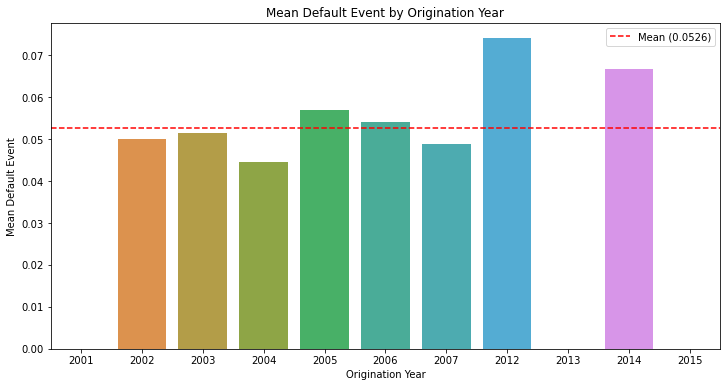

In [20]:
# Create a line plot of the mean 'default_event' by 'origination_date'
# Extract the year from the 'origination_date'
# Extract the year from the 'origination_date'
oneyear_pd['origination_year'] = pd.to_datetime(oneyear_pd['origination_date']).dt.year

# Create a bar plot of the mean 'default_event' by year
plt.figure(figsize=(12, 6))  # Set the figure size
sns.barplot(data=oneyear_pd, x='origination_year', y='default_event', ci=None)  # ci=None to remove confidence intervals

# Calculate the total mean of 'default_event'
total_mean = oneyear_pd['default_event'].mean()

# Add a horizontal line for the total mean
plt.axhline(total_mean, color='red', linestyle='--', label=f'Mean ({total_mean:.4f})')

# Set labels and title
plt.xlabel('Origination Year')
plt.ylabel('Mean Default Event')
plt.title('Mean Default Event by Origination Year')

# Show the plot
plt.legend()  # Show the legend with the total mean
plt.show()

#### Univariate Analysis

In [21]:
# Split the dataset into training and testing sets 70% vs 30%
train, test = train_test_split(oneyear_pd, test_size=0.3, random_state=42)

In [22]:
# WOE transform for bureau_score 
# There could be many different binning schemes, we could try it manually first to understand the processing
# Then we could use package such as scorecardpy/woe directly later)

# Assign WoE value -0.0910 to rows where 'bureau_score' is NaN
train.loc[train['bureau_score'].isna(), 'woe_bureau_score'] = -0.0910
# Assign WoE value -0.7994 to rows where 'bureau_score' is less than or equal to 308
train.loc[train['bureau_score'] <= 308, 'woe_bureau_score'] = -0.7994
# Assign WoE value -0.0545 to rows where 'bureau_score' is greater than 308 and less than or equal to 404
train.loc[(train['bureau_score'] > 308) & (train['bureau_score'] <= 404), 'woe_bureau_score'] = -0.0545
# Assign WoE value 0.7722 to rows where 'bureau_score' is greater than 404 and less than or equal to 483
train.loc[(train['bureau_score'] > 404) & (train['bureau_score'] <= 483), 'woe_bureau_score'] = 0.7722
# Assign WoE value 1.0375 to rows where 'bureau_score' is greater than 483
train.loc[train['bureau_score'] > 483, 'woe_bureau_score'] = 1.0375

In [23]:
# Assign WoE value -0.0910 to rows where 'bureau_score' is NaN
test.loc[test['bureau_score'].isna(), 'woe_bureau_score'] = -0.0910
# Assign WoE value -0.7994 to rows where 'bureau_score' is less than or equal to 308
test.loc[test['bureau_score'] <= 308, 'woe_bureau_score'] = -0.7994
# Assign WoE value -0.0545 to rows where 'bureau_score' is greater than 308 and less than or equal to 404
test.loc[(test['bureau_score'] > 308) & (test['bureau_score'] <= 404), 'woe_bureau_score'] = -0.0545
# Assign WoE value 0.7722 to rows where 'bureau_score' is greater than 404 and less than or equal to 483
test.loc[(test['bureau_score'] > 404) & (test['bureau_score'] <= 483), 'woe_bureau_score'] = 0.7722
# Assign WoE value 1.0375 to rows where 'bureau_score' is greater than 483
test.loc[test['bureau_score'] > 483, 'woe_bureau_score'] = 1.0375

In [24]:
# WoE transform for cc_util

#train dataframe

# Assign WoE value 0 to rows where 'cc_util' is NaN
train.loc[train['cc_util'].isna(), 'woe_cc_util'] = 0
# Assign WoE value 1.8323 to rows where 'cc_util' is less than or equal to 0.55
train.loc[train['cc_util'] <= 0.55, 'woe_cc_util'] = 1.8323
# Assign WoE value -0.4867 to rows where 'cc_util' is greater than 0.55 and less than or equal to 0.70
train.loc[(train['cc_util'] > 0.55) & (train['cc_util'] <= 0.70), 'woe_cc_util'] = -0.4867
# Assign WoE value -1.1623 to rows where 'cc_util' is greater than 0.70 and less than or equal to 0.85
train.loc[(train['cc_util'] > 0.70) & (train['cc_util'] <= 0.85), 'woe_cc_util'] = -1.1623
# Assign WoE value -2.3562 to rows where 'cc_util' is greater than 0.85
train.loc[train['cc_util'] > 0.85, 'woe_cc_util'] = -2.3562

# test dataframe

# Assign WoE value 0 to rows where 'cc_util' is NaN
test.loc[test['cc_util'].isna(), 'woe_cc_util'] = 0
# Assign WoE value 1.8323 to rows where 'cc_util' is less than or equal to 0.55
test.loc[test['cc_util'] <= 0.55, 'woe_cc_util'] = 1.8323
# Assign WoE value -0.4867 to rows where 'cc_util' is greater than 0.55 and less than or equal to 0.70
test.loc[(test['cc_util'] > 0.55) & (test['cc_util'] <= 0.70), 'woe_cc_util'] = -0.4867
# Assign WoE value -1.1623 to rows where 'cc_util' is greater than 0.70 and less than or equal to 0.85
test.loc[(test['cc_util'] > 0.70) & (test['cc_util'] <= 0.85), 'woe_cc_util'] = -1.1623
# Assign WoE value -2.3562 to rows where 'cc_util' is greater than 0.85
test.loc[test['cc_util'] > 0.85, 'woe_cc_util'] = -2.3562


In [25]:
# num_ccj
train.loc[train['num_ccj'].isna(), 'woe_num_ccj'] = -0.0910
train.loc[train['num_ccj'] <= 0, 'woe_num_ccj'] = 0.1877
train.loc[(train['num_ccj'] > 0) & (train['num_ccj'] <= 1), 'woe_num_ccj'] = -0.9166
train.loc[train['num_ccj'] > 1, 'woe_num_ccj'] = -1.1322

test.loc[test['num_ccj'].isna(), 'woe_num_ccj'] = -0.0910
test.loc[test['num_ccj'] <= 0, 'woe_num_ccj'] = 0.1877
test.loc[(test['num_ccj'] > 0) & (test['num_ccj'] <= 1), 'woe_num_ccj'] = -0.9166
test.loc[test['num_ccj'] > 1, 'woe_num_ccj'] = -1.1322

In [26]:
# max_arrears_12m'
train.loc[train['max_arrears_12m'].isna(), 'woe_max_arrears_12m'] = 0
train.loc[train['max_arrears_12m'] <= 0, 'woe_max_arrears_12m'] = 0.7027
train.loc[(train['max_arrears_12m'] > 0) & (train['max_arrears_12m'] <= 1), 'woe_max_arrears_12m'] = -0.8291
train.loc[(train['max_arrears_12m'] > 1) & (train['max_arrears_12m'] <= 1.4), 'woe_max_arrears_12m'] = -1.1908
train.loc[train['max_arrears_12m'] > 1.4, 'woe_max_arrears_12m'] = -2.2223

test.loc[test['max_arrears_12m'].isna(), 'woe_max_arrears_12m'] = 0
test.loc[test['max_arrears_12m'] <= 0, 'woe_max_arrears_12m'] = 0.7027
test.loc[(test['max_arrears_12m'] > 0) & (test['max_arrears_12m'] <= 1), 'woe_max_arrears_12m'] = -0.8291
test.loc[(test['max_arrears_12m'] > 1) & (test['max_arrears_12m'] <= 1.4), 'woe_max_arrears_12m'] = -1.1908
test.loc[test['max_arrears_12m'] > 1.4, 'woe_max_arrears_12m'] = -2.2223


In [27]:
# max_arrears_bal_6m
train.loc[train['max_arrears_bal_6m'].isna(), 'woe_max_arrears_bal_6m'] = 0
train.loc[train['max_arrears_bal_6m'] <= 0, 'woe_max_arrears_bal_6m'] = 0.5771
train.loc[(train['max_arrears_bal_6m'] > 0) & (train['max_arrears_bal_6m'] <= 300), 'woe_max_arrears_bal_6m'] = -0.7818
train.loc[(train['max_arrears_bal_6m'] > 300) & (train['max_arrears_bal_6m'] <= 600), 'woe_max_arrears_bal_6m'] = -1.2958
train.loc[(train['max_arrears_bal_6m'] > 600) & (train['max_arrears_bal_6m'] <= 900), 'woe_max_arrears_bal_6m'] = -1.5753
train.loc[train['max_arrears_bal_6m'] > 900, 'woe_max_arrears_bal_6m'] = -2.2110

test.loc[test['max_arrears_bal_6m'].isna(), 'woe_max_arrears_bal_6m'] = 0
test.loc[test['max_arrears_bal_6m'] <= 0, 'woe_max_arrears_bal_6m'] = 0.5771
test.loc[(test['max_arrears_bal_6m'] > 0) & (test['max_arrears_bal_6m'] <= 300), 'woe_max_arrears_bal_6m'] = -0.7818
test.loc[(test['max_arrears_bal_6m'] > 300) & (test['max_arrears_bal_6m'] <= 600), 'woe_max_arrears_bal_6m'] = -1.2958
test.loc[(test['max_arrears_bal_6m'] > 600) & (test['max_arrears_bal_6m'] <= 900), 'woe_max_arrears_bal_6m'] = -1.5753
test.loc[test['max_arrears_bal_6m'] > 900, 'woe_max_arrears_bal_6m'] = -2.2110


In [28]:
# Employment length (years)
train.loc[train['emp_length'].isna(), 'woe_emp_length'] = 0
train.loc[train['emp_length'] <= 2, 'woe_emp_length'] = -0.7514
train.loc[(train['emp_length'] > 2) & (train['emp_length'] <= 4), 'woe_emp_length'] = -0.3695
train.loc[(train['emp_length'] > 4) & (train['emp_length'] <= 7), 'woe_emp_length'] = 0.1783
train.loc[train['emp_length'] > 7, 'woe_emp_length'] = 0.5827

test.loc[test['emp_length'].isna(), 'woe_emp_length'] = 0
test.loc[test['emp_length'] <= 2, 'woe_emp_length'] = -0.7514
test.loc[(test['emp_length'] > 2) & (test['emp_length'] <= 4), 'woe_emp_length'] = -0.3695
test.loc[(test['emp_length'] > 4) & (test['emp_length'] <= 7), 'woe_emp_length'] = 0.1783
test.loc[test['emp_length'] > 7, 'woe_emp_length'] = 0.5827


In [29]:
# months_since_recent_cc_delinq
train.loc[train['months_since_recent_cc_delinq'].isna(), 'woe_months_since_recent_cc_delinq'] = 0
train.loc[train['months_since_recent_cc_delinq'] <= 6, 'woe_months_since_recent_cc_delinq'] = -0.4176
train.loc[(train['months_since_recent_cc_delinq'] > 6) & (train['months_since_recent_cc_delinq'] <= 11), 'woe_months_since_recent_cc_delinq'] = -0.1942
train.loc[train['months_since_recent_cc_delinq'] > 11, 'woe_months_since_recent_cc_delinq'] = 1.3166

test['woe_months_since_recent_cc_delinq'] = np.nan
test.loc[test['months_since_recent_cc_delinq'].isna(), 'woe_months_since_recent_cc_delinq'] = 0
test.loc[test['months_since_recent_cc_delinq'] <= 6, 'woe_months_since_recent_cc_delinq'] = -0.4176
test.loc[(test['months_since_recent_cc_delinq'] > 6) & (test['months_since_recent_cc_delinq'] <= 11), 'woe_months_since_recent_cc_delinq'] = -0.1942
test.loc[test['months_since_recent_cc_delinq'] > 11, 'woe_months_since_recent_cc_delinq'] = 1.3166

In [30]:
# annual_income
train.loc[train['annual_income'].isna(), 'woe_annual_income'] = 0
train.loc[train['annual_income'] <= 35064, 'woe_annual_income'] = -1.8243
train.loc[(train['annual_income'] > 35064) & (train['annual_income'] <= 41999), 'woe_annual_income'] = -0.8272
train.loc[(train['annual_income'] > 41999) & (train['annual_income'] <= 50111), 'woe_annual_income'] = -0.3294
train.loc[(train['annual_income'] > 50111) & (train['annual_income'] <= 65050), 'woe_annual_income'] = 0.2379
train.loc[train['annual_income'] > 65050, 'woe_annual_income'] = 0.6234

test.loc[test['annual_income'].isna(), 'woe_annual_income'] = 0
test.loc[test['annual_income'] <= 35064, 'woe_annual_income'] = -1.8243
test.loc[(test['annual_income'] > 35064) & (test['annual_income'] <= 41999), 'woe_annual_income'] = -0.8272
test.loc[(test['annual_income'] > 41999) & (test['annual_income'] <= 50111), 'woe_annual_income'] = -0.3294
test.loc[(test['annual_income'] > 50111) & (test['annual_income'] <= 65050), 'woe_annual_income'] = 0.2379
test.loc[test['annual_income'] > 65050, 'woe_annual_income'] = 0.6234

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18134 entries, 21739 to 23654
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   id                                 18134 non-null  int64         
 1   vintage_year                       18134 non-null  int64         
 2   monthly_installment                18134 non-null  float64       
 3   loan_balance                       18134 non-null  float64       
 4   bureau_score                       17846 non-null  float64       
 5   num_bankrupt_iva                   17846 non-null  float64       
 6   time_since_bankrupt                17846 non-null  float64       
 7   num_ccj                            17846 non-null  float64       
 8   time_since_ccj                     17846 non-null  float64       
 9   ccj_amount                         17846 non-null  float64       
 10  num_bankrupt                  

In [32]:
pip install scorecardpy

Note: you may need to restart the kernel to use updated packages.


In [33]:
pip install woe

Note: you may need to restart the kernel to use updated packages.


In [34]:
import scorecardpy as sc

# Perform IV analysis
features_to_analyze = ['woe_bureau_score', 'woe_cc_util', 'woe_num_ccj',
       'woe_max_arrears_bal_6m', 'woe_emp_length',
       'woe_months_since_recent_cc_delinq', 'woe_annual_income']
iv_df = sc.iv(train, y='default_event', x=features_to_analyze)

# Print IV values
print(iv_df)

                            variable  info_value
1                        woe_cc_util    1.890697
3             woe_max_arrears_bal_6m    0.889556
6                  woe_annual_income    0.519880
0                   woe_bureau_score    0.498704
5  woe_months_since_recent_cc_delinq    0.416614
4                     woe_emp_length    0.178858
2                        woe_num_ccj    0.143283


In [35]:
# Perform IV analysis
features_to_analyze = ['id', 'vintage_year', 'monthly_installment', 'loan_balance',
       'bureau_score', 'num_bankrupt_iva', 'time_since_bankrupt',
       'num_ccj', 'time_since_ccj', 'ccj_amount', 'num_bankrupt',
       'num_iva', 'min_months_since_bankrupt', 'pl_flag', 'region', 'ltv',
       'arrears_months', 'origination_date', 'maturity_date',
       'repayment_type', 'arrears_status', 'arrears_segment', 'mob',
       'remaining_mat', 'loan_term', 'live_status', 'repaid_status',
       'month', 'worst_arrears_status', 'max_arrears_12m', 'recent_arrears_date',
       'months_since_2mia', 'avg_mia_6m', 'max_arrears_bal_6m',
       'max_mia_6m', 'avg_bal_6m', 'avg_bureau_score_6m', 'cc_util',
       'annual_income', 'emp_length', 'months_since_recent_cc_delinq',
       'origination_year']
iv_df_1 = sc.iv(train, y='default_event', x=features_to_analyze)

# Print IV values
print(iv_df_1)

                         variable  info_value
29                max_arrears_12m    2.378823
16                 arrears_months    2.038999
33             max_arrears_bal_6m    1.793611
9                      ccj_amount    1.538633
4                    bureau_score    0.996283
20                 arrears_status    0.934574
36            avg_bureau_score_6m    0.895083
28           worst_arrears_status    0.876124
21                arrears_segment    0.863283
34                     max_mia_6m    0.739653
30            recent_arrears_date    0.738107
31              months_since_2mia    0.738107
17               origination_date    0.714176
40  months_since_recent_cc_delinq    0.699041
18                  maturity_date    0.691178
23                  remaining_mat    0.676257
37                        cc_util    0.416350
32                     avg_mia_6m    0.377131
15                            ltv    0.356203
24                      loan_term    0.316478
8                  time_since_ccj 

In [38]:
# Try logistic model with WoE 

logistic_model = LogisticRegression(random_state=42)
X_train = train[['woe_bureau_score', 'woe_cc_util', 'woe_num_ccj',
       'woe_max_arrears_bal_6m', 'woe_emp_length',
       'woe_months_since_recent_cc_delinq', 'woe_annual_income']]
y_train = train['default_event']
X_test =  test[['woe_bureau_score', 'woe_cc_util', 'woe_num_ccj',
       'woe_max_arrears_bal_6m', 'woe_emp_length',
       'woe_months_since_recent_cc_delinq', 'woe_annual_income']]
y_test = test['default_event']
logistic_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [39]:
y_pred = logistic_model.predict(X_test)

In [40]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')


Accuracy: 0.9557385486361297
Confusion Matrix:
[[7277   51]
 [ 293  151]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7328
           1       0.75      0.34      0.47       444

    accuracy                           0.96      7772
   macro avg       0.85      0.67      0.72      7772
weighted avg       0.95      0.96      0.95      7772



### Lifetime PD

- Data preparation
- GLM modeling
- Survival Modeling
- Transition Matrix Modeling

In [6]:
lifetime_pd = pd.read_csv("lifetime_pd.csv")
print(lifetime_pd.shape) # 42442 records
print(lifetime_pd.head())
print(lifetime_pd.columns)

(42442, 34)
        id report_date  year  quarter  month    balance origination_date  \
0  1002023  2003-03-31  2003        1      3   41304.36       2001-07-26   
1  1002023  2003-06-30  2003        2      6   40287.72       2001-07-26   
2  1002023  2003-09-30  2003        3      9   39252.42       2001-07-26   
3  1002023  2003-12-31  2003        4     12   38214.28       2001-07-26   
4  1002920  2008-06-30  2008        2      6  108395.53       2008-04-29   

  maturity_date repayment_type  loan_term  ...    gdp  uer  cpi     hpi    ir  \
0    2011-07-26      Repayment        120  ...  3.221  5.2  1.5  25.108  4.32   
1    2011-07-26      Repayment        120  ...  3.397  4.9  1.3  22.336  4.28   
2    2011-07-26      Repayment        120  ...  3.644  5.0  1.4  18.882  4.57   
3    2011-07-26      Repayment        120  ...  3.597  4.9  1.3  16.817  4.92   
4    2033-04-29  Interest Only        300  ...  1.005  5.3  3.4  -5.192  4.87   

    gdp_lag  uer_lag  cpi_lag    hpi_lag  lt

### LGD Modeling
- LGD data preparation
- LGD micro-structure approach
- LGD Regression methods


In [41]:
lgd = pd.read_csv("lgd.csv")
print(lgd.shape)
print(lgd.head())
print(lgd.columns)

(430, 14)
  new_loan_id  balance_at_default  shortfall  flag_sold  net_sale_proceeds  \
0      N11901           170203.44   24385.20          1          152990.38   
1      N11902            60368.09   40210.91          1           29237.60   
2      N11903           207838.69   56582.39          1          156550.00   
3      N11904            73736.79   62337.83          1           17373.07   
4      N11905           132064.54     526.52          1          127810.00   

   balance_at_wo   ltv_utd  index_value_new  time_since_default  \
0      177375.58  0.448436        271673.43                  72   
1       69448.51  0.838799         64880.89                  72   
2      213132.39  0.522509        233595.34                  72   
3       79710.90  1.231607         60396.20                  72   
4      128336.52  0.400000        126315.47                  72   

  repayment_type_segment  tob  months_to_maturity region  shortfall_balance_wo  
0                     IO  164        

### Prepayment, Competing Risks and EAD Modeling
- Data preparation
- Full prepayment modeling
- Competing risk modeling
- EAD modeling


In [42]:
prepay= pd.read_csv("bal_prep.csv")
print(prepay.shape) # 37346 records
print(prepay.head())
print(prepay.columns)

(37346, 25)
   X       id report_date  year  quarter  month   balance origination_date  \
0  1  1000170  2004-03-31  2004        1      3  44576.69       1999-09-17   
1  2  1000170  2004-06-30  2004        2      6  44145.22       1999-09-17   
2  3  1000170  2004-09-30  2004        3      9  43714.65       1999-09-17   
3  4  1000170  2004-12-31  2004        4     12  43276.97       1999-09-17   
4  5  1000170  2005-03-31  2005        1      3  42816.81       1999-09-17   

  maturity_date  loan_term  ...  part_prep_flag    gdp  uer  cpi     hpi  \
0    2019-09-17        240  ...               0  3.332  4.8  1.3  17.301   
1    2019-09-17        240  ...               0  2.890  4.8  1.4  19.598   
2    2019-09-17        240  ...               0  2.069  4.7  1.3  19.287   
3    2019-09-17        240  ...               0  1.844  4.7  1.4  14.396   
4    2019-09-17        240  ...               0  1.859  4.7  1.7   9.882   

     ir  multi_flag  pp_new  fppp_perc  ltv_utd  
0  4.73     

In [43]:
ead = pd.read_csv("ead.csv")
print(ead.shape) # 366 records
print(ead.head())
print(ead.columns)

(366, 14)
       id report_date  year    balance  default_flag    gdp  uer  cpi     hpi  \
0  335679  2008-09-30  2008   89182.01             1 -1.449  5.9  4.8 -11.483   
1  342540  2008-06-30  2008  291269.44             1  1.005  5.3  3.4  -5.192   
2  343423  2011-03-31  2011  177314.43             1  2.262  7.8  4.1  -1.533   
3  346117  2004-12-31  2004  109932.69             1  1.844  4.7  1.4  14.396   
4  358929  2007-03-31  2007   66443.00             1  1.751  5.5  2.9  10.433   

     ir  uti_def_orig   uti_def   uti_ini  ccf_ratio  
0  4.75      0.371927  0.371927  0.166529   2.233406  
1  4.87      0.288527  0.288527  0.483252   0.597053  
2  3.89      0.736082  0.736082  0.210035   3.504565  
3  4.62      0.490713  0.490713  0.210162   2.334927  
4  4.75      0.478016  0.478016  0.187626   2.547710  
Index(['id', 'report_date', 'year', 'balance', 'default_flag', 'gdp', 'uer',
       'cpi', 'hpi', 'ir', 'uti_def_orig', 'uti_def', 'uti_ini', 'ccf_ratio'],
      dtype='obje

### Scenario Analysis and CECL 
- Data preparation
- Scenario Analysis
- CECL Computation and valuatation

In [44]:
macrov = pd.read_csv("macrov.csv")
print(macrov.shape) # 54 records
print(macrov.head(10))
print(macrov.columns)

(54, 7)
     DATE    LN_GDP    LN_CPI     LN_EQ     LN_FX      IR_S      IR_L
0  1999Q4  4.584177  4.584590  3.750966 -5.069477  0.012903  0.011275
1  2000Q1  4.595223  4.593452  3.740157 -5.070681  0.014103  0.011474
2  2000Q2  4.602494  4.603311  3.720306 -5.027500  0.014347  0.011363
3  2000Q3  4.608425  4.608944  3.741641 -4.999077  0.014111  0.011594
4  2000Q4  4.614437  4.614893  3.709038 -4.987262  0.013819  0.011315
5  2001Q1  4.623570  4.616626  3.664815 -4.987400  0.013132  0.011116
6  2001Q2  4.624728  4.621873  3.628357 -4.978310  0.012269  0.012134
7  2001Q3  4.630711  4.626059  3.510211 -4.998041  0.011530  0.012015
8  2001Q4  4.634632  4.625188  3.513670 -4.992250  0.009621  0.011450
9  2002Q1  4.639813  4.628679  3.517691 -4.978993  0.009541  0.011999
Index(['DATE', 'LN_GDP', 'LN_CPI', 'LN_EQ', 'LN_FX', 'IR_S', 'IR_L'], dtype='object')


### Conclusions



-
-


#### References: https://www.tizianobellini.com/
